<h1><center>Assignment 5 </center></h1>
<h2><center> SC9502B </center></h2>
<h3><center> Yasamin Modabber </center></h3>
<link rel="stylesheet" type="text/css" href="./text.css">

$\textbf{Question 1}$: Construct an interpolating polynomial for the function $f(x) = e^{−x^2}$ with 11 nodes (n = 10) using the SciPy barycentric_interpolate function for each of the choice of nodes given below on the interval $[−1, 1]$. For each case, plot the original 11 points sampled from $f(x)$ (as symbols) and at least 100 points of the interpolating function. Also, plot a separate graph of the error $(|f(x)−p10(x)|)$ using at least 100 points.

a) Evenly spaced points

b) Chebyshev nodes

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import barycentric_interpolate

f = lambda x: np.exp(-1*np.power(x,2))  # The function f(x) = e^(-x^2)

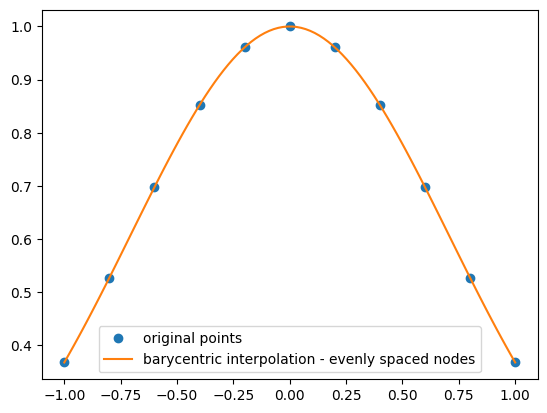

In [107]:
# For evenly spaced nodes
x_nodes = np.linspace(-1.0, 1.0, 11)
y_nodes = f(x_nodes)
points=100
x_bar = np.linspace(min(x_nodes), max(x_nodes), points)
y_bar = barycentric_interpolate(x_nodes, y_nodes, x_bar)
plt.plot(x_nodes, y_nodes, "o", label="original points")
plt.plot(x_bar, y_bar, label="barycentric interpolation - evenly spaced nodes")
plt.legend()
plt.show()

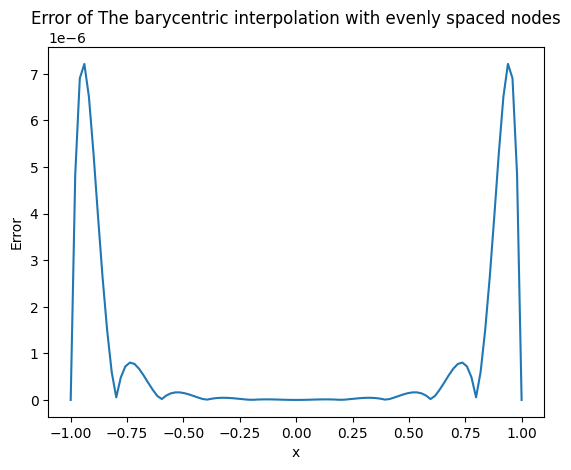

In [108]:
# A graph of the error:
error = np.abs(f(x_bar) - y_bar)
plt.title("Error of The barycentric interpolation with evenly spaced nodes")
plt.xlabel("x")
plt.ylabel("Error")
plt.plot(x_bar, error)

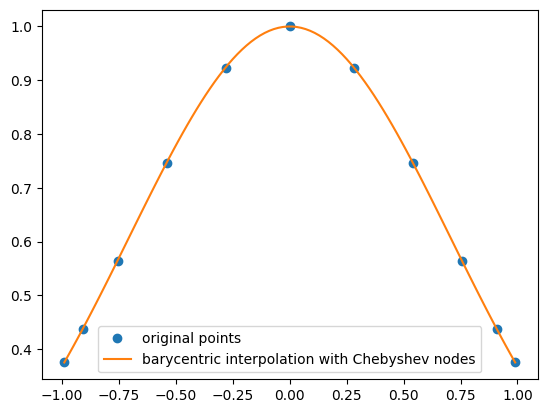

In [109]:
# For Chebyshev nodes
chebyshev_nodes = lambda i,n : np.cos((2*i+1)/(2*n+2) * np.pi)
n_ch=10
x_nch = np.array([chebyshev_nodes(i, n_ch) for i in range(n_ch+1)])
y_nch = f(x_nch)
points=100
x_bar = np.linspace(min(x_nch), max(x_nch), points)
y_bar = barycentric_interpolate(x_nch, y_nch, x_bar)
plt.plot(x_nch, y_nch, "o", label="original points")
plt.plot(x_bar, y_bar, label="barycentric interpolation with Chebyshev nodes")
plt.legend()
plt.show()

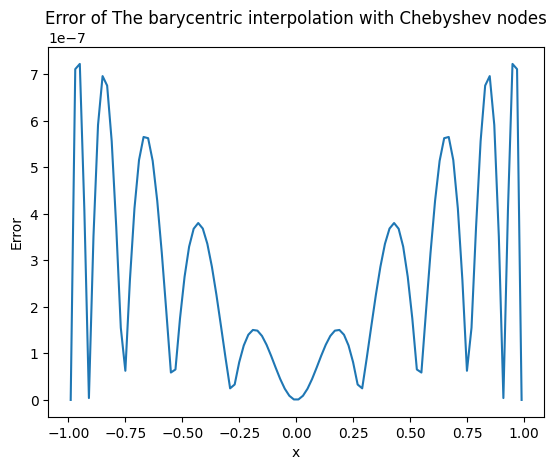

In [110]:
# A graph of the error:
error = np.abs(f(x_bar) - y_bar)
plt.title("Error of The barycentric interpolation with Chebyshev nodes")
plt.xlabel("x")
plt.ylabel("Error")
plt.plot(x_bar, error)

$\textbf{Question 2}$: Write your own function to construct a natural cubic spline. It should return arrays or lists of the
coefficients $a_j$ , $b_j$ , $c_j$ , and $d_j$ for the splines given an input set of points $x_j$ and function values
$f(x_j)$. You can use the SciPy scipy.linalg.solve _banded function. Test your function by
comparing it to the SciPy interp1d function for the function $f(x) = e^{−x^2}$ .

In [111]:
from scipy.linalg import solve_banded

The general form of the splines is:
$S_j(x) = a_j + b_j (x - x_j) + c_j (x - x_j)^2 , d_j (x - x_j) ^3$.

Our goal is to find coefficients $a_j$ , $b_j$ , $c_j$ , and $d_j$ for node j where j= 0, 1 , 2 , .. , n

For natural cubic spline, we have the following boundary condition:

$S^{''}(x_0)=0$ & $S^{''}(x_n)=0$

We have the following conditions for each of the nodes:

1. $S_j(x_j) = f(x_j)$
2. $S_j(x_{j+1}) = S_{j+1}(x_{j+1})$
3. $S_j'(x_{j+1}) = S_{j+1}'(x_{j+1})$
4. $S_j''(x_{j+1}) = S_{j+1}''(x_{j+1})$

In [115]:
# S_j = a_j + b_j(x-x_j) + c_j(x-x_j)^2 + d_j(x-x_j)^3

def natural_cubic_spline(x_i,y_j,n):
    a_j = y_j # Values for a_j are found from the function values
    b_j = np.zeros(n)
    c_j = np.zeros(n)
    d_j = np.zeros(n)
    h = np.zeros(n)
    for i in range(n):
        h[i] = x_i[i+1] - x_i[i]
    # Solving the linear system Ax=b to fing c_j
    # The matrix A is:
    A = np.zeros((n,n))
    A[0][0] = 1
    for i in range(1,n-1):
        A[i][i-1] = h[i-1]
        A[i][i] = 2*(h[i-1]+h[i])
        A[i][i+1] = h[i]
    A[n-1][n-1] = 2*(h[n-2]+h[n-1])
    A[n-1][n-2] = h[n-2]

    # array b is:
    b = np.zeros(n)
    for i in range(1,n-1):
        b[i] = 3 * ((a_j[i+1]-a_j[i]) / h[i]) - 3* ((a_j[i]-a_j[i-1]) / h[i-1])

    # Turning the n x n matrix A into a banded matrix so we can solve the system of equations using solve_banded
    A_banded = np.zeros((3,n))
    for i in range(1,n):
        A_banded[0][i] = A[i][i-1]
    for i in range(n):
        A_banded[1][i] = A[i][i]
    for i in range(n-1):
        A_banded[2][i] = A[i+1][i]

    # c_j coefficient:
    c_j = solve_banded((1,1), A_banded, b)

    for i in range(n-1): # b_j and d_j are found to be:
        d_j[i] = (c_j[i+1] - c_j[i])/(3*h[i]) 
        b_j[i] = (a_j[i+1] - a_j[i])/h[i] - h[i]*(2*c_j[i] + c_j[i+1])/3
        
    return a_j, b_j, c_j, d_j

Now that we have all the parametes, we can evaluate s(x) at the specific points x in the interval $[a,b]$. we need to determine which interval $[x_j, x_{j+1}]$ the value x falls into and then evaluate and return $s_j(x)$. To do that, we write the function find_j:

In [79]:
def find_j(x , x_j):
    for j in range(len(x_j)):
        if x < x_j[j]:
            return j-1
    return len(x_j)-2 #return the last interval

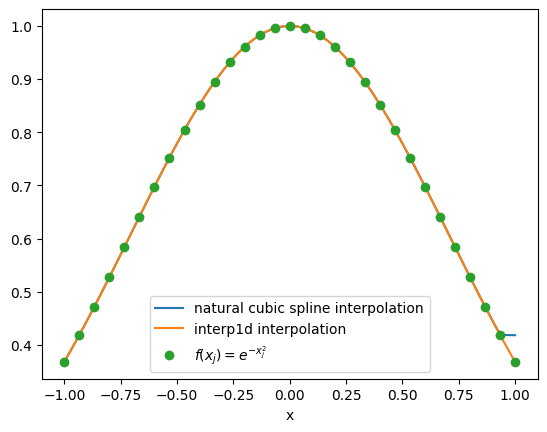

In [82]:
from scipy.interpolate import interp1d

# Sample calculation:
points=31 # number of points to divide the interval [a,b] into 
n=points-1 # j=0,1,2,...,n-1
a_bound=-1 # lower bound
b_bound=1 # upper bound

x_j = np.linspace(a_bound,b_bound,points)
#natural cubic spline coefficients for input set x_j are :
a, b, c, d = natural_cubic_spline(x_j,f(x_j),n)

#plotting the natural cubic spline
x_ncs=np.linspace(a_bound,b_bound,100)
y_ncs=np.zeros(100)
for i in range(100):
    j = find_j(x_ncs[i],x_j)
    y_ncs[i] = a[j] + b[j]*(x_ncs[i]-x_j[j]) + c[j]*(x_ncs[i]-x_j[j])**2 + d[j]*(x_ncs[i]-x_j[j])**3 

#comparing with interp1d:
func_interp1d = interp1d(x_j, f(x_j), kind='cubic')
y_interp1d = func_interp1d(x_ncs)

plt.plot(x_ncs,y_ncs,label="natural cubic spline interpolation")
plt.plot(x_ncs,y_interp1d,label="interp1d interpolation")
plt.plot(x_j,f(x_j),"o",label="$f(x_j) = e^{-x_j^2}$")
plt.xlabel("x")
plt.legend()

We can see that our natural cubic spline interpolation closely follows the interpolation done with interp1d closely.